# Expanded Baseline Model

In order to more thoroughly test the baseline model, a single node decision tree, I will train it using a simple heuristic in order to find an ideal discrimination threshold and then test the threshold on a test set.

## Function Definitions and Imports

In [1]:
import json

# Default threshold function
def get_f1(thresh, term_freqs, solution):
    # Predict
    predictions = {}
    for doc in term_freqs.keys():
        predictions[doc] = [key for key, val in term_freqs[doc].items() if val > thresh]
        
    # Get evaluation metrics
    true_pos = 0
    false_pos = 0
    false_neg = 0
    
    for pmid in predictions:
        true_pos += len([pred for pred in predictions[pmid] if pred in solution[pmid]])
        false_pos += len([pred for pred in predictions[pmid] if pred not in solution[pmid]])
        false_neg += len([sol for sol in solution[pmid] if sol not in predictions[pmid]])

    if true_pos == 0:
        precision = 0
        recall = 0
        f1 = 0
    else:
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        f1 = (2 * precision * recall) / (precision + recall)
    
    return f1

def train(term_freqs, solution):
    curr_thresh = 0.0
    step_val = 0.001
    f1s = []
    
    f1s.append(get_f1(curr_thresh, term_freqs, solution))
    f1s.append(get_f1(curr_thresh + step_val, term_freqs, solution))
    
    curr_thresh += step_val
    next_thresh_f1 = get_f1(curr_thresh + step_val, term_freqs, solution)
    
    while not (next_thresh_f1 < f1s[-1] and next_thresh_f1 < f1s[-2] and f1s[-1] < f1s[-2]):
        curr_thresh += step_val
        f1s.append(get_f1(curr_thresh, term_freqs, solution))
        next_thresh_f1 = get_f1(curr_thresh + step_val, term_freqs, solution)
    
    return curr_thresh - step_val

def predict(test_freqs, thresh, solution):
    # Test it out
    predictions = {}

    # Predict
    for doc in test_freqs.keys():
        predictions[doc] = [key for key, val in test_freqs[doc].items() if val > thresh]
    
    return predictions

In [2]:
# Load in term frequencies and partition
with open("./data/term_freqs_rev_3_all_terms.json", "r") as handle:
    temp = json.load(handle)

docs_list = list(temp.keys())
partition = int(len(docs_list) * .8)

train_docs = docs_list[0:partition]
test_docs = docs_list[partition:]

# Load in solution values
solution = {}
docs_list = set(docs_list)
with open("./data/pm_doc_term_counts.csv", "r") as handle:
    for line in handle:
        line = line.strip("\n").split(",")
        if line[0] in docs_list:
            # Only use samples indexed with MeSH terms
            terms = [term for term in line[1:] if term]
            if terms:
                solution[line[0]] = terms
                
# Build training/test data, ensure good solution data is available
# Solution data is not always available because documents may not be
# indexed - even though obviously some of their references have been indexed
train_freqs = {}
for doc in train_docs:
    if doc in solution.keys():
        train_freqs[doc] = temp[doc]

test_freqs = {}
for doc in test_docs:
    if doc in solution.keys():
        test_freqs[doc] = temp[doc]  

In [29]:
# Load in MeSH data
term_names = {}
mean_term_depths = {}
with open("./data/mesh_data.tab", "r") as handle:
    for line in handle:
        line = line.strip("\n").split("\t")
        term_names[line[0]] = line[1]
        mean_depth = 0
        posits = [len(posit.split(".")) for posit in line[4].split(",")]
        mean_term_depths[line[0]] = sum(posits) / len(posits)
            
uids = list(term_names.keys())

In [9]:
thresh = train(train_freqs, solution)

preds = predict(test_freqs, thresh, solution)

true_pos = 0
false_pos = 0
false_neg = 0

for pmid in preds:
    true_pos += len([pred for pred in preds[pmid] if pred in solution[pmid]])
    false_pos += len([pred for pred in preds[pmid] if pred not in solution[pmid]])
    false_neg += len([sol for sol in solution[pmid] if sol not in preds[pmid]])

if true_pos == 0:
    precision = 0
    recall = 0
    f1 = 0
else:
    mi_precision = true_pos / (true_pos + false_pos)
    mi_recall = true_pos / (true_pos + false_neg)
    mi_f1 = (2 * precision * recall) / (precision + recall)

ma_ps = []
ma_rs = []
ma_f1s = []

for uid in uids:
    true_pos = 0
    false_pos = 0
    false_neg = 0
    
    for pmid in preds:
        if uid in preds[pmid] and uid in solution[pmid]:
            true_pos += 1
        if uid in preds[pmid] and uid not in solution[pmid]:
            false_pos += 1
        if uid in solution[pmid] and uid not in preds[pmid]:
            false_neg += 1
    
    if true_pos == 0:
        precision = 0
        recall = 0
        f1 = 0
    else:
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        f1 = (2 * precision * recall) / (precision + recall)

    if true_pos + false_pos + false_neg > 0:
        ma_ps.append(precision)
        ma_rs.append(recall)
        ma_f1s.append(f1)

ma_f1 = sum(ma_f1s) / len(ma_f1s)
ma_recall = sum(ma_rs) / len(ma_rs)
ma_precision = sum(ma_ps) / len(ma_ps)

ex_ps = []
ex_rs = []
ex_f1s = []

for pmid in preds:
    true_pos = len([pred for pred in preds[pmid] if pred in solution[pmid]])
    false_pos = len([pred for pred in preds[pmid] if pred not in solution[pmid]])
    false_neg = len([sol for sol in solution[pmid] if sol not in preds[pmid]])

    if true_pos == 0:
        precision = 0
        recall = 0
        f1 = 0
    else:
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        f1 = (2 * precision * recall) / (precision + recall)

    ex_ps.append(precision)
    ex_rs.append(recall)
    ex_f1s.append(f1)

ex_f1 = sum(ex_f1s) / len(ex_f1s)
ex_recall = sum(ex_rs) / len(ex_rs)
ex_precision = sum(ex_ps) / len(ex_ps)

print(f"Learned discrimination threshold: {thresh}\n")
print(f"Micro-averaged F1 from test set: {mi_f1}")
print(f"Micro-averaged precision from test set: {mi_precision}")
print(f"Micro-averaged recall from test set: {mi_recall}\n")

print(f"Macro-averaged F1 from test set: {ma_f1}")
print(f"Macro-averaged precision from test set: {ma_precision}")
print(f"Macro-averaged recall from test set: {ma_recall}\n")

print(f"Example-based F1 from test set: {ex_f1}")
print(f"Example-based precision from test set: {ex_precision}")
print(f"Example-based recall from test set: {ex_recall}\n")

Learned discrimination threshold: 0.016000000000000007

Micro-averaged F1 from test set: 0.5185185185185185
Micro-averaged precision from test set: 0.4835427147497974
Micro-averaged recall from test set: 0.44848679773565053

Macro-averaged F1 from test set: 0.2707060659683809
Macro-averaged precision from test set: 0.3435499654320987
Macro-averaged recall from test set: 0.2610917648722886

Example-based F1 from test set: 0.45872013278246604
Example-based precision from test set: 0.5098678216699748
Example-based recall from test set: 0.47528414518345835



I'm also curious about what some of these results look like, so I'm going to modify the predict function in order to record the F1s for each sample (example-based F1), and separately the F1s for each sample with more than 20 MeSH terms applied to all of its citations.

In [4]:
def predict(test_freqs, thresh, solution):
    predictions = {}
    f1s = {}
    f1s_all = {}
    
    # Predict
    for doc in test_freqs.keys():
        predictions[doc] = [key for key, val in test_freqs[doc].items() if val > thresh]

    for pmid in predictions:
        true_pos = len([pred for pred in predictions[pmid] if pred in solution[pmid]])
        false_pos = len([pred for pred in predictions[pmid] if pred not in solution[pmid]])
        false_neg = len([sol for sol in solution[pmid] if sol not in predictions[pmid]])

        if true_pos == 0:
            precision = 0
            recall = 0
            f1 = 0
        else:
            precision = true_pos / (true_pos + false_pos)
            recall = true_pos / (true_pos + false_neg)
            f1 = (2 * precision * recall) / (precision + recall)
        if len(predictions[pmid]) > 20:
            f1s[pmid] = f1
            
        f1s_all[pmid] = f1
        
    return f1s, f1s_all, predictions
        
f1s, f1s_all, predictions = predict(test_freqs, 0.016, solution)

In [15]:
max_f1 = max(f1s.values())
min_f1 = min(f1s.values())

sorted_f1s = sorted([[key, val] for key, val in f1s.items()], key=lambda item: item[1], reverse=True)
max_pmids = sorted_f1s[0:10]
med_pmids = [samp for samp in sorted_f1s if samp[1] > 0.44 and samp[1] < 0.46][0:2]
min_pmids = [key for key, value in f1s.items() if value == min_f1]

print(f"Maximum F1: {max_f1}")
print(f"Minimum F1: {min_f1}, found for {len(min_pmids)} PMIDs")

Maximum F1: 0.9500000000000001
Minimum F1: 0, found for 8 PMIDs


Let's look at the predictions and solutions for the best scoring samples.

In [23]:
max_preds = "; ".join(sorted([term_names[pred] for pred in predictions[max_pmids[0][0]]]))
max_sol = "; ".join(sorted(list(dict.fromkeys([term_names[sol] for sol in solution[max_pmids[0][0]]]))))
print(f"F1 score for {max_pmids[0][0]}: {f1s[max_pmids[0][0]]}")
print(f"Predicted terms ({len(predictions[max_pmids[0][0]])}) for PMID {max_pmids[0][0]}: \n{max_preds}")
print(f"\nActual terms ({len(solution[max_pmids[0][0]])}) applied to PMID {max_pmids[0][0]}: \n{max_sol}")
print(f"\nNumber of MeSH terms applied to all of {max_pmids[0][0]}'s references: {len(test_freqs[max_pmids[0][0]].keys())}\n")

max_preds = "; ".join(sorted([term_names[pred] for pred in predictions[max_pmids[1][0]]]))
max_sol = "; ".join(sorted([term_names[sol] for sol in solution[max_pmids[1][0]]]))
print(f"F1 score for {max_pmids[1][0]}: {f1s[max_pmids[1][0]]}")
print(f"Predicted terms ({len(predictions[max_pmids[1][0]])}) for PMID {max_pmids[1][0]}: \n{max_preds}")
print(f"\nActual terms ({len(solution[max_pmids[1][0]])}) applied to PMID {max_pmids[1][0]}: \n{max_sol}")
print(f"\nNumber of MeSH terms applied to all of {max_pmids[1][0]}'s references: {len(test_freqs[max_pmids[1][0]].keys())}")

F1 score for 23314745: 0.9500000000000001
Predicted terms (21) for PMID 23314745: 
Adolescent; Adult; Antiviral Agents; Child; Child, Preschool; Drug Therapy, Combination; Female; Genotype; Hepacivirus; Hepatitis C, Chronic; Humans; Interferon alpha-2; Interferon-alpha; Interleukins; Male; Polyethylene Glycols; Polymorphism, Single Nucleotide; Recombinant Proteins; Ribavirin; Treatment Outcome; Viral Load

Actual terms (19) applied to PMID 23314745: 
Adolescent; Antiviral Agents; Child; Child, Preschool; Drug Therapy, Combination; Female; Genotype; Hepacivirus; Hepatitis C, Chronic; Humans; Interferon-alpha; Interleukins; Male; Polyethylene Glycols; Polymorphism, Single Nucleotide; Recombinant Proteins; Ribavirin; Treatment Outcome; Viral Load

Number of MeSH terms applied to all of 23314745's references: 98

F1 score for 28789709: 0.8571428571428571
Predicted terms (21) for PMID 28789709: 
Adult; Aged; Aged, 80 and over; Antineoplastic Agents; Carcinoma, Renal Cell; Disease-Free Survi

This is pretty good. 23314745 had 98 terms applied to all and 21 were selected for prediction based on their relative frequency being greater than the discrimination threshold. However, samples like this are bound to occur when evaluating this much data.

Let's also take a look at a couple of the worst predictions.

In [22]:
min_preds = ", ".join([term_names[pred] for pred in predictions[min_pmids[0]]])
min_sol = ", ".join([term_names[sol] for sol in solution[min_pmids[0]]])
print(f"F1 score for {min_pmids[0]}: {f1s[min_pmids[0]]}")
print(f"Predicted terms for PMID {min_pmids[0]}: \n{min_preds}")
print(f"\nActual terms applied to PMID {min_pmids[0]}: \n{min_sol}")
print(f"\nNumber of MeSH terms applied to all of {min_pmids[0]}'s references: {len(test_freqs[min_pmids[0]].keys())}")

min_preds = ", ".join([term_names[pred] for pred in predictions[min_pmids[1]]])
min_sol = ", ".join([term_names[sol] for sol in solution[min_pmids[1]]])
print(f"\nF1 score for {min_pmids[1]}: {f1s[min_pmids[1]]}")
print(f"Predicted terms for PMID {min_pmids[1]}: \n{min_preds}")
print(f"\nActual terms applied to PMID {min_pmids[1]}: \n{min_sol}")
print(f"\nNumber of MeSH terms applied to all of {min_pmids[1]}'s references: {len(test_freqs[min_pmids[1]].keys())}")

F1 score for 21932250: 0
Predicted terms for PMID 21932250: 
Base Sequence, DNA Primers, Escherichia coli, Fermentation, Gene Deletion, Genetic Engineering, Genome, Bacterial, Molecular Sequence Data, Plasmids, Succinic Acid, Templates, Genetic, Anaerobiosis, Biosynthetic Pathways, Butylene Glycols, Glucose, Organisms, Genetically Modified, Alcohol Dehydrogenase, Aldehyde Reductase, Butanols, Cloning, Molecular, Escherichia coli Proteins, Fungal Proteins, Recombinant Proteins

Actual terms applied to PMID 21932250: 
Biofuels, Biomass, Biotechnology, Industrial Microbiology, Metabolic Engineering, Synthetic Biology

Number of MeSH terms applied to all of 21932250's references: 23

F1 score for 23721330: 0
Predicted terms for PMID 23721330: 
Dental Models, Humans, Imaging, Three-Dimensional, Reproducibility of Results, Analysis of Variance, Cephalometry, Computer-Aided Design, Image Processing, Computer-Assisted, Malocclusion, Observer Variation, Odontometry, Software, Computer Simulatio

And a couple of the average predictions:

In [16]:
med_preds = "; ".join(sorted([term_names[pred] for pred in predictions[med_pmids[0][0]]]))
med_sol = "; ".join(sorted(list(dict.fromkeys([term_names[sol] for sol in solution[med_pmids[0][0]]]))))
print(f"F1 score for {med_pmids[0][0]}: {f1s[med_pmids[0][0]]}")
print(f"Predicted terms ({len(predictions[med_pmids[0][0]])}) for PMID {med_pmids[0][0]}: \n{med_preds}")
print(f"\nActual terms ({len(solution[med_pmids[0][0]])}) applied to PMID {med_pmids[0][0]}: \n{med_sol}")
print(f"\nNumber of MeSH terms applied to all of {med_pmids[0][0]}'s references: {len(test_freqs[med_pmids[0][0]].keys())}\n")

med_preds = "; ".join(sorted([term_names[pred] for pred in predictions[med_pmids[1][0]]]))
med_sol = "; ".join(sorted([term_names[sol] for sol in solution[med_pmids[1][0]]]))
print(f"F1 score for {med_pmids[1][0]}: {f1s[med_pmids[1][0]]}")
print(f"Predicted terms ({len(predictions[med_pmids[1][0]])}) for PMID {med_pmids[1][0]}: \n{med_preds}")
print(f"\nActual terms ({len(solution[med_pmids[1][0]])}) applied to PMID {med_pmids[1][0]}: \n{med_sol}")
print(f"\nNumber of MeSH terms applied to all of {med_pmids[1][0]}'s references: {len(test_freqs[med_pmids[1][0]].keys())}")

F1 score for 3133340: 0.459016393442623
Predicted terms (45) for PMID 3133340: 
Animals; Antineoplastic Agents; Biological Transport; Biotransformation; Body Weight; Chlorides; Clinical Trials as Topic; Creatinine; Cyclophosphamide; Cytarabine; Dialysis; Diffusion; Dose-Response Relationship, Drug; Doxorubicin; Drug Tolerance; Female; Fluorouracil; Humans; Kinetics; Liver; Mammals; Metabolic Clearance Rate; Methotrexate; Mice; Mice, Inbred BALB C; Mice, Nude; Mitomycin; Mitomycins; Models, Biological; Neoplasm Transplantation; Neoplasms, Experimental; Nimustine; Nitrosourea Compounds; Organ Specificity; Pharmaceutical Preparations; Pharmacology; Research Design; Species Specificity; Statistics as Topic; Stomach Neoplasms; Thermodynamics; Thiopental; Time Factors; Transplantation, Heterologous; Vincristine

Actual terms (16) applied to PMID 3133340: 
Animals; Antineoplastic Agents; Clinical Trials as Topic; Humans; Mice; Mice, Inbred BALB C; Mice, Nude; Mitomycin; Mitomycins; Neoplasms,

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'F1 Score')]

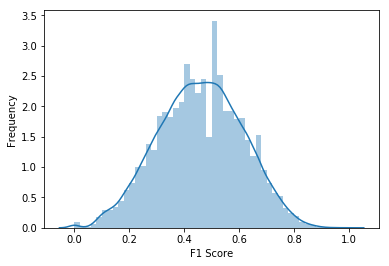

In [47]:
import seaborn as sns
import numpy as np

f1_vals = np.array(list(f1s_all.values()))
ax = sns.distplot(f1_vals)
ax.set(xlabel="F1 Score", ylabel="Frequency")

The distribution of F1 scores for samples in the test set. 

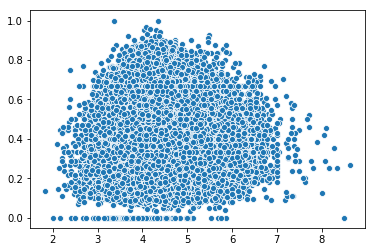

In [35]:
import seaborn as sns
from numpy import median

y_f1s = []
x_med_depth = []
for sample in f1s_all:
    y_f1s.append(f1s_all[sample])
    depths = [mean_term_depths[uid] for uid in solution[sample]]
    x_med_depth.append(sum(depths) / len(depths))
    #x_med_depth.append(median(depths))

sns.scatterplot(x=x_med_depth, y=y_f1s)

I'm also interested in which terms have been classified corrrectly and incorrectly, so I'm going to modify the predict function again to track this.

In [38]:
def predict(test_freqs, thresh, solution):
    predictions = {}
    f1s = {}
    f1s_all = {}
    
    true_pos = []
    false_pos = []
    false_neg = []
    
    # Predict
    for doc in test_freqs.keys():
        predictions[doc] = [key for key, val in test_freqs[doc].items() if val > thresh]

    for pmid in predictions:
        true_pos.extend([pred for pred in predictions[pmid] if pred in solution[pmid]])
        false_pos.extend([pred for pred in predictions[pmid] if pred not in solution[pmid]])
        false_neg.extend([sol for sol in solution[pmid] if sol not in predictions[pmid]])
        
    return true_pos, false_pos, false_neg

true_pos, false_pos, false_neg = predict(test_freqs, 0.016, solution)

Most frequent true positive terms and their counts: 
Humans - 42759
Female - 22519
Male - 20879
Animals - 17463
Middle Aged - 12379
Adult - 11683
Aged - 8478
Mice - 5836
Adolescent - 3145
Child - 2199


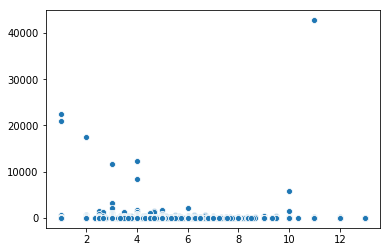

In [40]:
from collections import Counter

true_pos = Counter(true_pos)
true_pos_counts = [[key, val] for key, val in true_pos.items()]
true_pos_counts = sorted(true_pos_counts, key=lambda true_pos_counts: true_pos_counts[1], reverse=True)
print("Most frequent true positive terms and their counts: ")
for item in true_pos_counts[0:10]:
    print(f"{term_names[item[0]]} - {item[1]}")

y = []
x = []
for item in true_pos_counts:
    x.append(mean_term_depths[item[0]])
    y.append(item[1])
    
sns.scatterplot(x=x, y=y)

Most frequent false positive terms and their counts: 
Male - 12887
Animals - 12820
Female - 12743
Adult - 11732
Humans - 11000
Middle Aged - 9665
Aged - 8247
Molecular Sequence Data - 6485
Mice - 6080
Adolescent - 4584


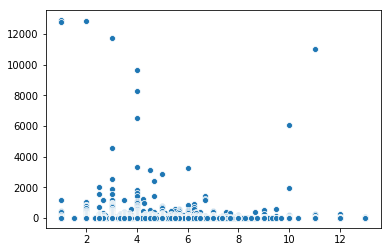

In [41]:
false_pos = Counter(false_pos)
false_pos_counts = [[key, val] for key, val in false_pos.items()]
false_pos_counts = sorted(false_pos_counts, key=lambda false_pos_counts: false_pos_counts[1], reverse=True)
false_pos_counts[:10]
print("Most frequent false positive terms and their counts: ")
for item in false_pos_counts[0:10]:
    print(f"{term_names[item[0]]} - {item[1]}")
    
y = []
x = []
for item in false_pos_counts:
    x.append(mean_term_depths[item[0]])
    y.append(item[1])
    
sns.scatterplot(x=x, y=y)

Most frequent false negative terms and their counts: 
Young Adult - 4240
Time Factors - 2451
Aged, 80 and over - 2296
Female - 2009
Treatment Outcome - 1956
Aged - 1938
Adolescent - 1924
Retrospective Studies - 1912
Male - 1880
Adult - 1835


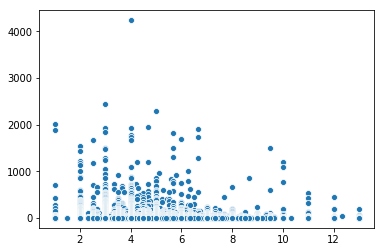

In [42]:
false_neg = Counter(false_neg)
false_neg_counts = [[key, val] for key, val in false_neg.items()]
false_neg_counts = sorted(false_neg_counts, key=lambda false_neg_counts: false_neg_counts[1], reverse=True)
false_neg_counts[:10]
print("Most frequent false negative terms and their counts: ")
for item in false_neg_counts[0:10]:
    print(f"{term_names[item[0]]} - {item[1]}")
    
y = []
x = []
for item in false_neg_counts:
    x.append(mean_term_depths[item[0]])
    y.append(item[1])
    
sns.scatterplot(x=x, y=y)